In [ ]:
Generation of simulated images
------------------------------

Here, the idea is to test whether compressed sensing can be applied to realistic imaging conditions by using careful simulations. To do so, we start from two sources of data (termed ground truth - **GT**):

1. Experimental images
2. Simulated images

We then generate noisy counterparts of those images, by adding both Poisson and Gaussian noise followed by compression of a variable compression ratio (from 2 to 20). Images are then reconstructed with or without a PSF model and metrics are computed.

In [64]:
## Various imports
%matplotlib inline
from libtiff import TIFF ## Now works with Python 3 !
import matplotlib.pyplot as plt
import numpy as np
import spams
import os, sys, time, pickle
import pandas
from scipy import misc
import scipy.ndimage
from skimage.measure import structural_similarity as ssim
sys.path.append('../../3_code/')
import cstools

p_psf = "../../5_outputs/psf_models/lattice_161114.npy" ## A PSF model
psf = np.load(p_psf) ## Load PSF

# 1. Input images
## 1a. Experimental data

(100, 512, 101)


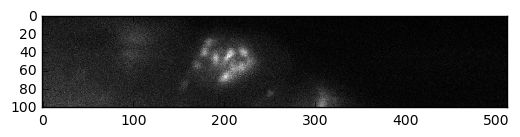

In [65]:
exp_p = "../../4_data/lattice-lightsheet/em/m_ch0_stack0000_4nm_0000000msec_0012698237msecAbs.tif" ## Keep only 100 frames
exp = cstools.read_tif(exp_p, div2=False)[100:200,:,:]

print exp.shape
plt.imshow(exp[99,:,:].T, cmap='gray', interpolation='none')

## 1b. Simulated images

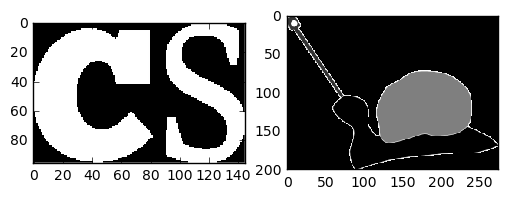

In [328]:
shape = np.array([512, 101])

# Load the base patterns
prim_cs = 255-misc.imread("./primitives/cs.png")[:,:,0]
prim_el = 255-misc.imread("./primitives/elmerscargot.png")[:,:,0]
padding = np.max((prim_cs.shape, prim_el.shape))


plt.subplot(121); plt.imshow(prim_cs, cmap='gray', interpolation='none')
plt.subplot(122); plt.imshow(prim_el, cmap='gray', interpolation='none')

In [336]:
def escargot_tout_chaud(shape):
    """Returns a cool image"""
    im =  np.zeros(shape+2*padding)

    ## Draw random integer to position the guys
    X = np.random.randint(0, .8*shape[0], 2)
    Y = np.random.randint(0, .8*shape[1], 2)
    R = np.random.rand(2)*360 # Rotation range
    Z = (.7-.2)*np.random.rand(2)+.2 # [.1, .5]

    tmp_cs = scipy.ndimage.interpolation.zoom(scipy.ndimage.interpolation.rotate(prim_cs, R[0]), Z[0])
    tmp_el = scipy.ndimage.interpolation.zoom(scipy.ndimage.interpolation.rotate(prim_el, R[1]), Z[1])

    s_cs = tmp_cs.shape
    s_el = tmp_el.shape
    
    im[(X[0]+padding):(X[0]+padding+s_cs[0]),(Y[0]+padding):(Y[0]+padding+s_cs[1])] += tmp_cs
    im[(X[1]+padding):(X[1]+padding+s_el[0]),(Y[1]+padding):(Y[1]+padding+s_el[1])] += tmp_el

    return im[padding:-padding,padding:-padding]

def etc(shape):
    while 1:
        try:
            return escargot_tout_chaud(shape)
            break
        except:
            pass

In [337]:
## Generate a reproducible dataset
np.random.seed(42)
sim = np.zeros((100, shape[0], shape[1]))

for i in range(100):
    sim[i,:,:] = etc(shape)

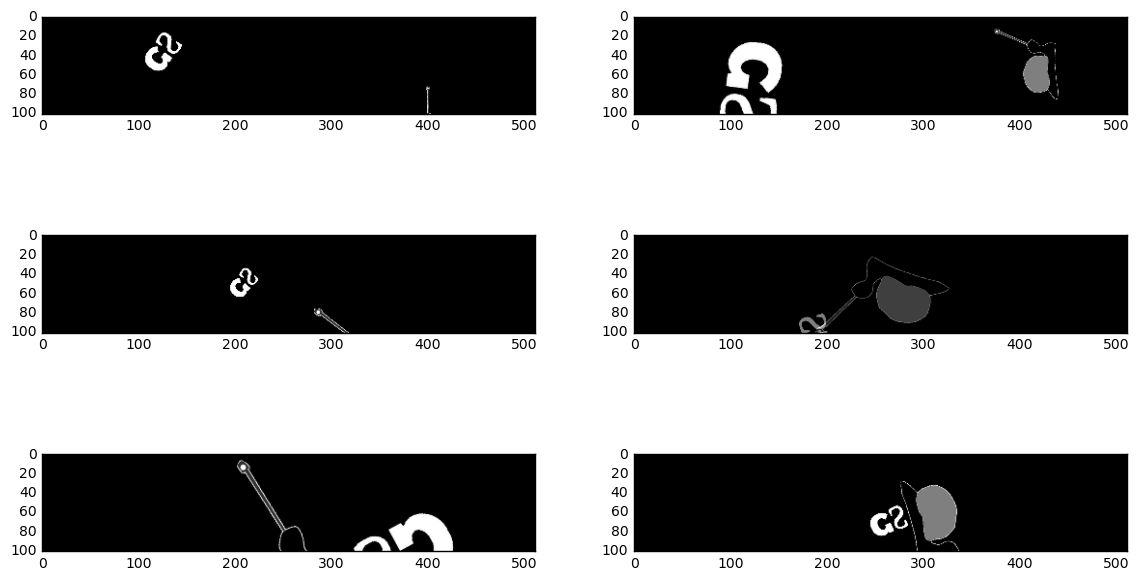

In [339]:
plt.figure(figsize=(14,8))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(sim[i,:,:].T, cmap='gray')

## 1c. Scale to 5000 photons

In [340]:
signal = 10000
exp = exp.astype(float)
sim = sim.astype(float)

exp = np.int_((exp*signal)/exp.max())
for i in range(sim.shape[0]):
    sim[i,:,:] = np.int_((sim[i,:,:]*signal)/sim[i,:,:].max())

# 2. Compression in a noisy setting
## 2a. PSF loading and measurement matrix

(101, 5928) (404, 1482)


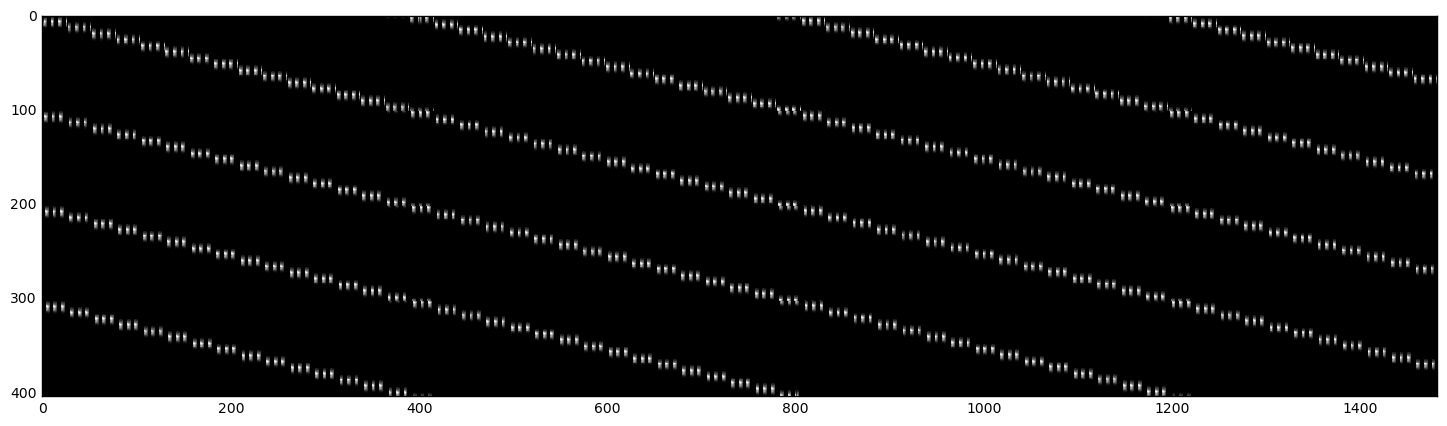

In [341]:
step = 8 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.

l=np.zeros((exp.shape[2], 2*psf.shape[1]))
l[:psf.shape[0],:psf.shape[1]]=psf
ll=[]
for j in range(step*int(exp.shape[2]/psf.shape[0])+1):
    for k in range(2*psf.shape[0]):
        ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])

D1 = np.hstack(ll) ## This is the dictionary.
D2 = np.hstack([i.T.reshape((-1,1)) for i in ll])

print D1.shape, D2.shape
plt.figure(figsize=(18,5))
plt.imshow(D2, cmap='gray', interpolation="none")

## Generate measurement matrix
#b=cstools.generate_fourier_basis(101, 150+1, sample=False, oldmethod=True)
b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)
b_norm = b/b.shape[1] ## Normalize the illumination intensity
B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2)

## 2b. Add noise

We first add Poisson noise. Note that the noise depends on both the signal and the illumination pattern, which makes it a little bit weird to compute (see below the `add_poisson` function).

We then adjust the SNR by adding Gaussian noise (actually, values drawn from a half-normal distribution). A *half-normal distribution* is the distribution generated by $|X|$, where $X \sim \mathcal{N}(0,\sigma)$. In particular, it has expected value $\mathbb{E}(X) = \sigma \sqrt\frac{2}{\pi}$.

In [342]:
def add_poisson(exp, b_norm):
    """Returns a compressed stack with Poisson noise"""
    exp_comp = np.zeros((exp.shape[0], exp.shape[1], b.shape[0]))
    for f in range(exp.shape[0]): ## All across the stack
        exp_comp[f,:,:] = np.random.poisson(cstools.measure(exp[f,:,:], b_norm))
    return exp_comp

def add_gaussian(exp, snr):
    """Adds Gaussian noise to a given SNR (provided that the number of photons is conserved)"""

exp_comp = add_poisson(exp, b_norm) ## Add Poisson noise to the experimental stack
sim_comp = add_poisson(sim, b) ## Add Poisson noise to the simulated stack

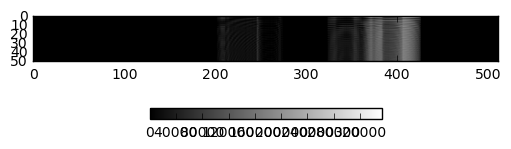

In [343]:
# Visualize the results
plt.imshow(sim_comp[4,:,:].T, cmap='gray')
plt.colorbar(orientation='horizontal', shrink=0.5)

In [629]:
## Create a compressed dataset.
SNR = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 70, 80, np.inf]

exp_nois = []
sim_nois = []

def get_signal(im):
    n = float(im[im!=0].mean())
    #print "Signal level is: {}".format(n)
    return n

for snr in SNR:
    print "Adding noise at a SNR of {}".format(snr)
        
    im = add_poisson(exp, b_norm)
    n_exp = get_signal(exp)/snr # Compute noise value    
    if n_exp>0:
        im = np.abs(im + np.random.normal(0, .5*n_exp*(np.pi/2)**.5, size=im.shape)) ## We assume that the noise level is proportional to the illumination intensity
    exp_nois.append(im)
    
    im = add_poisson(sim, b_norm)  ## Add GAUSSIAN here
    n_sim = get_signal(sim)/snr # Compute noise value    
    if n_exp>0:
        im = np.abs(im + np.random.normal(0, .5*n_sim*(np.pi/2)**.5*.5, size=im.shape))             
    sim_nois.append(im)  

 Adding noise at a SNR of 1
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 2
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 3
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 4
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 5
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 6
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 7
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 8
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 9
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 10
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a SNR of 15
Signal level is: 657.005777769
Signal level is: 5788.03931059
Adding noise at a 

In [43]:
## Save everything in one file (that can be sent to the tars cluster and that is easy to index)
for i in range(len(SNR)):
    snr = SNR[i]
    print snr
    with open('./simulations/simulations_{}_snr{}.pkl'.format('exp', snr), 'w') as f:
        pickle.dump({'dat':exp_nois[i], 'snr': SNR}, f)
    with open('./simulations/simulations_{}_snr{}.pkl'.format('sim', snr), 'w') as f:
        pickle.dump({'dat':sim_nois[i], 'snr': SNR}, f)      
        
print "There are {} reconstructions to perform".format(2*len(sim_nois)*sim_nois[0].shape[0])

There are 3200 reconstructions to perform


# 3. Reconstruction for all different settings

Use a version that can easily be sent to a job array to the TARS cluster.

In [625]:
def spiral(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000, noisetype='poisson')
def spiral2(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)
def spiral_tv(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000, penalty='tv')

## Reconstruction in 1D
def reco_image(ima, verbose=True, tv=False, comp=None, rand=False):
    """A simple piece of code to perform a 1D reconstruction"""
    if comp == None:
        c = range(b_norm.shape[0])
    else:
        c = range(int(b_norm.shape[1]/comp))
    if rand:
        c = range(4, b_norm.shape[0])
        np.random.shuffle(c)
        c = range(4)+c
        c = c[:int(b_norm.shape[1]/comp)]
    if tv:
        re = spiral_tv(ima[:,c].T, b_norm[c,:]).T
    else:
        re = spiral2(ima[:,c].T, b_norm[c,:]).T
    return re

ij = 0
j = 14
im1 = reco_image(sim_nois[ij][j,:,:], tv=False, comp=5, rand=True)
im2 = reco_image(sim_nois[ij][j,:,:], tv=False, comp=5, rand=False)
print "Reconstruction performed for a SNR of {}".format(SNR[ij])

Reconstruction performed for a SNR of 1


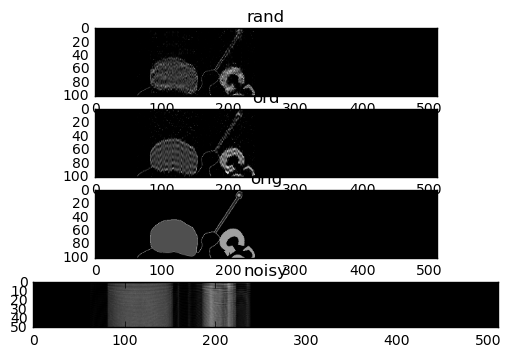

In [626]:
plt.subplot(411);plt.imshow(im1.T, cmap='gray');plt.title("rand")
plt.subplot(412);plt.imshow(im2.T, cmap='gray');plt.title("ord")
plt.subplot(413);plt.imshow(sim[j,:,:].T, cmap='gray');plt.title("orig")
plt.subplot(414);plt.imshow(sim_nois[ij][j,:,:].T, cmap='gray');plt.title("noisy")

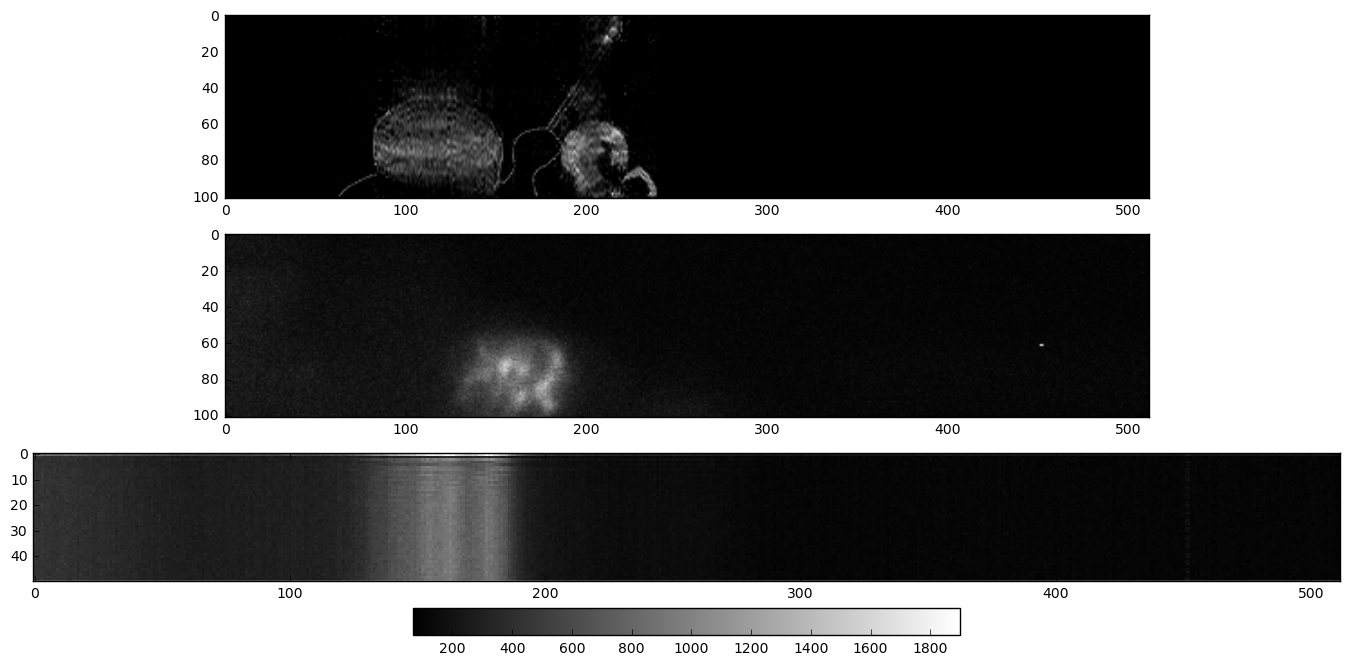

In [610]:
plt.figure(figsize=(18,8))
plt.subplot(311)
plt.imshow(im1.T, cmap='gray')
plt.subplot(312)
if SNR[ij] != np.inf:
    plt.imshow(np.abs(np.random.poisson(exp[j,:,:])+np.random.normal(0, get_signal(exp)/SNR[ij]*(np.pi/2)**.5, size=sim[90,:,:].shape)).T, cmap='gray')
else:
    plt.imshow(np.abs(np.random.poisson(exp[j,:,:])).T, cmap='gray')
#plt.imshow(np.abs(np.random.poisson(exp[j,:,:]/SNR[ij])).T, cmap='gray')

plt.subplot(313)
plt.imshow(exp_nois[ij][j,:,:].T, cmap='gray', interpolation='none')
plt.colorbar(orientation='horizontal', shrink=.7)

In [ ]:
## Reconstruction in 2D
def reco_image2(ima, verbose=True, tv=False):
    rr1 = np.arange(0, ima.shape[0]-psf.shape[1], 1)
    rr2 = rr1 + psf.shape[1]
    #im = np.zeros_like(eye[0,:,:].T)
    im = np.zeros((b.shape[1], ima.shape[0]))
    for (i,j) in enumerate(zip(rr1,rr2)):
        if verbose and i%100 == 0:
            print "{}/{}".format(i, len(rr1))
        (sta,sto) = j
        im_sub = ima[range(sta,sto),:].flatten()
        if tv:
            r_sim = spiral_tv(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        else:
            r_sim = spiral(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        im[:,sta:sto]+=r_sim.T
    return im

im = reco_image2(np.int_(exp_nois[-1][90,:,:])) # Algorithm seems more stable in that case

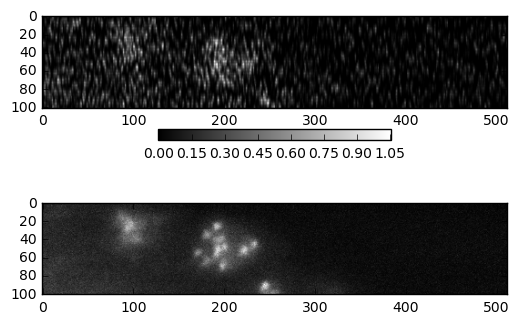

In [367]:
plt.subplot(211)

plt.imshow(im, cmap='gray')
plt.colorbar(orientation='horizontal', shrink=0.5)

plt.subplot(212)
plt.imshow(exp[90,:,:].T+np.abs(np.random.normal(0, 5000/30*(np.pi/2)**.5, size=sim[0,:,:].T.shape)), cmap='gray')

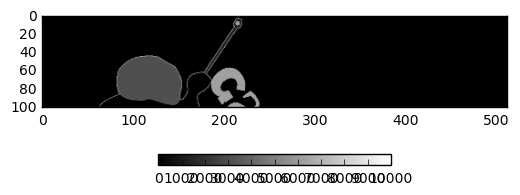

In [507]:
#plt.subplot(211)
#plt.imshow(im, cmap='gray')
#plt.colorbar(orientation='horizontal', shrink=0.5)

#plt.subplot(212)
plt.imshow(sim[14,:,:].T, cmap='gray')
plt.colorbar(orientation='horizontal', shrink=0.5)

In [431]:
rec_exp2 = [np.zeros_like(exp) for i in SNR]
MSE_exp2 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_exp2 = [np.zeros((exp.shape[0])) for i in SNR]

rec_sim2 = [np.zeros_like(sim) for i in SNR]
MSE_sim2 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_sim2 = [np.zeros((exp.shape[0])) for i in SNR]

rec_exp5 = [np.zeros_like(exp) for i in SNR]
MSE_exp5 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_exp5 = [np.zeros((exp.shape[0])) for i in SNR]

rec_sim5 = [np.zeros_like(sim) for i in SNR]
MSE_sim5 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_sim5 = [np.zeros((exp.shape[0])) for i in SNR]

rec_exp10 = [np.zeros_like(exp) for i in SNR]
MSE_exp10 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_exp10 = [np.zeros((exp.shape[0])) for i in SNR]

rec_sim10 = [np.zeros_like(sim) for i in SNR]
MSE_sim10 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_sim10 = [np.zeros((exp.shape[0])) for i in SNR]

rec_exp20 = [np.zeros_like(exp) for i in SNR]
MSE_exp20 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_exp20 = [np.zeros((exp.shape[0])) for i in SNR]

rec_sim20 = [np.zeros_like(sim) for i in SNR]
MSE_sim20 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_sim20 = [np.zeros((exp.shape[0])) for i in SNR]

rec_exp30 = [np.zeros_like(exp) for i in SNR]
MSE_exp30 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_exp30 = [np.zeros((exp.shape[0])) for i in SNR]

rec_sim30 = [np.zeros_like(sim) for i in SNR]
MSE_sim30 = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_sim30 = [np.zeros((exp.shape[0])) for i in SNR]

SSIM_expref = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_simref = [np.zeros((sim.shape[0])) for i in SNR]
MSE_expref = [np.zeros((exp.shape[0])) for i in SNR]
MSE_simref = [np.zeros((sim.shape[0])) for i in SNR]

## Full noise reference
SSIM_expnoiref = [np.zeros((exp.shape[0])) for i in SNR]
MSE_expnoiref = [np.zeros((exp.shape[0])) for i in SNR]
SSIM_simnoiref = [np.zeros((sim.shape[0])) for i in SNR]
MSE_simnoiref = [np.zeros((sim.shape[0])) for i in SNR]

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    # There is a bijection between PSNR and MSE: PSNR = 10*log(255*255/MSE) / log(10)
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [630]:
j = 14
for ij in range(len(SNR)):
    r = reco_image(exp_nois[ij][j,:,:], tv=False)
    rec_exp2[ij][j,:,:] = r
    MSE_exp2[ij][j] = mse(exp[j,:,:], r)
    SSIM_exp2[ij][j] = ssim(exp[j,:,:].astype(np.float64), r)
print "Exp2: Reconstruction performed"

for ij in range(len(SNR)):
    r = reco_image(sim_nois[ij][j,:,:], tv=False)
    rec_sim2[ij][j,:,:] = r
    MSE_sim2[ij][j] = mse(sim[j,:,:], r)
    SSIM_sim2[ij][j] = ssim(sim[j,:,:].astype(np.float64), r)
print "Sim2: Reconstruction performed"
    
for ij in range(len(SNR)):
    r = reco_image(exp_nois[ij][j,:,:], comp=5, tv=False)
    rec_exp5[ij][j,:,:] = r
    MSE_exp5[ij][j] = mse(exp[j,:,:], r)
    SSIM_exp5[ij][j] = ssim(exp[j,:,:].astype(np.float64), r)
print "Exp5: Reconstruction performed"

for ij in range(len(SNR)):
    r = reco_image(sim_nois[ij][j,:,:], comp=5, tv=False)
    rec_sim5[ij][j,:,:] = r
    MSE_sim5[ij][j] = mse(sim[j,:,:], r)
    SSIM_sim5[ij][j] = ssim(sim[j,:,:].astype(np.float64), r)
print "Sim5: Reconstruction performed"
    
for ij in range(len(SNR)):
    r = reco_image(exp_nois[ij][j,:,:], comp=10, tv=False)
    rec_exp10[ij][j,:,:] = r
    MSE_exp10[ij][j] = mse(exp[j,:,:], r)
    SSIM_exp10[ij][j] = ssim(exp[j,:,:].astype(np.float64), r)
print "Exp10: Reconstruction performed"
    
for ij in range(len(SNR)):
    r = reco_image(sim_nois[ij][j,:,:], comp=10, tv=False)
    rec_sim10[ij][j,:,:] = r
    MSE_sim10[ij][j] = mse(sim[j,:,:], r)
    SSIM_sim10[ij][j] = ssim(sim[j,:,:].astype(np.float64), r)
print "Sim10: Reconstruction performed"

for ij in range(len(SNR)):
    r = reco_image(exp_nois[ij][j,:,:], comp=20, tv=False)
    rec_exp20[ij][j,:,:] = r
    MSE_exp20[ij][j] = mse(exp[j,:,:], r)
    SSIM_exp20[ij][j] = ssim(exp[j,:,:].astype(np.float64), r)
print "Exp20: Reconstruction performed"

for ij in range(len(SNR)):
    r = reco_image(sim_nois[ij][j,:,:], comp=20, tv=False)
    rec_sim20[ij][j,:,:] = r
    MSE_sim20[ij][j] = mse(sim[j,:,:], r)
    SSIM_sim20[ij][j] = ssim(sim[j,:,:].astype(np.float64), r)
print "Sim20: Reconstruction performed"

for ij in range(len(SNR)):
    r = reco_image(exp_nois[ij][j,:,:], comp=30, tv=False)
    rec_exp30[ij][j,:,:] = r
    MSE_exp30[ij][j] = mse(exp[j,:,:], r)
    SSIM_exp30[ij][j] = ssim(exp[j,:,:].astype(np.float64), r)
print "Exp30: Reconstruction performed"

for ij in range(len(SNR)):
    r = reco_image(sim_nois[ij][j,:,:], comp=30, tv=False)
    rec_sim30[ij][j,:,:] = r
    MSE_sim30[ij][j] = mse(sim[j,:,:], r)
    SSIM_sim30[ij][j] = ssim(sim[j,:,:].astype(np.float64), r)
print "Sim30: Reconstruction performed"

Exp2: Reconstruction performed
Sim2: Reconstruction performed
Exp5: Reconstruction performed
Sim5: Reconstruction performed
Exp10: Reconstruction performed
Sim10: Reconstruction performed
Exp20: Reconstruction performed
Sim20: Reconstruction performed
Exp30: Reconstruction performed
Sim30: Reconstruction performed


In [612]:
for ij in range(len(SNR)):
    snr = SNR[ij]
    print "SNR of {}".format(snr)
    if snr != np.inf:
        exp_n = np.abs(np.random.poisson(exp[j,:,:])+np.random.normal(0, get_signal(exp)/snr*(np.pi/2)**.5, size=exp[90,:,:].shape))
    else:
        exp_n = exp[j,:,:].astype(np.float64)
    SSIM_expref[ij][j] = ssim(exp[j,:,:].astype(np.float64), exp_n)
    MSE_expref[ij][j] = mse(exp[j,:,:], exp_n)
             
    if snr != np.inf:
        sim_n = np.abs(np.random.poisson(sim[j,:,:])+np.random.normal(0, get_signal(sim)/snr*(np.pi/2)**.5, size=sim[90,:,:].shape))
    else:
        sim_n = sim[j,:,:].astype(np.float64)
    SSIM_simref[ij][j] = ssim(sim[j,:,:].astype(np.float64), sim_n)
    MSE_simref[ij][j] = mse(sim[j,:,:], sim_n)   
    
for ij in range(len(SNR)):
    snr = SNR[ij]
    print "SNR of {}".format(snr)
    if snr != np.inf:
        exp_n = np.abs(np.random.normal(0, get_signal(exp)/snr*(np.pi/2)**.5, size=exp[90,:,:].shape))
    else:
        exp_n = exp[j,:,:].astype(np.float64)
    SSIM_expnoiref[ij][j] = ssim(exp[j,:,:].astype(np.float64), exp_n)
    MSE_expnoiref[ij][j] = mse(exp[j,:,:], exp_n)
    SSIM_simnoiref[ij][j] = ssim(sim[j,:,:].astype(np.float64), exp_n)
    MSE_simnoiref[ij][j] = mse(sim[j,:,:], exp_n) 

SNR of 1
SNR of 2
SNR of 3
SNR of 4
SNR of 5
SNR of 6
SNR of 7
SNR of 8
SNR of 9
SNR of 10
SNR of 15
SNR of 20
SNR of 30
SNR of 50
SNR of 70
SNR of 80
SNR of inf
SNR of 1
SNR of 2
SNR of 3
SNR of 4
SNR of 5
SNR of 6
SNR of 7
SNR of 8
SNR of 9
SNR of 10
SNR of 15
SNR of 20
SNR of 30
SNR of 50
SNR of 70
SNR of 80
SNR of inf


(0, 20)

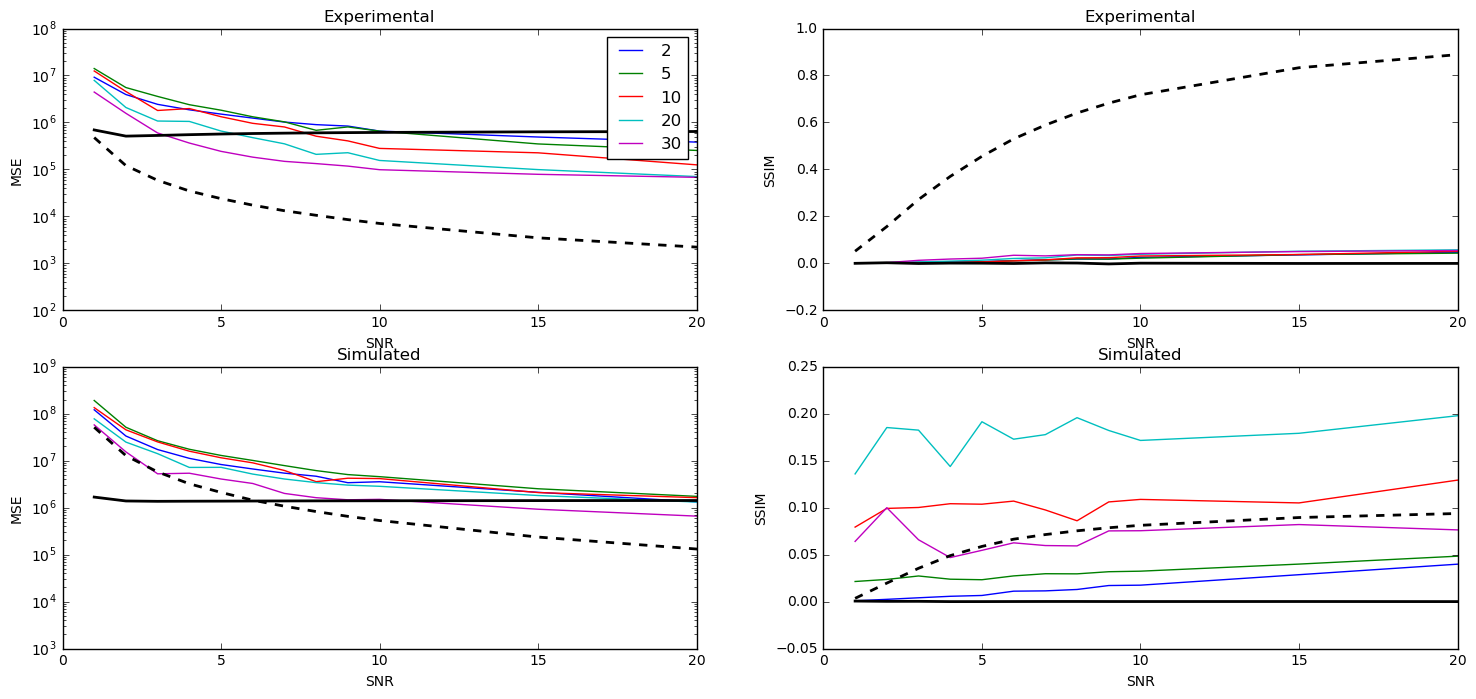

In [632]:
j=14
comp = [2,5,10,20,30]
MSE_exp = [MSE_exp2, MSE_exp5, MSE_exp10, MSE_exp20, MSE_exp30]
SSIM_exp = [SSIM_exp2, SSIM_exp5, SSIM_exp10, SSIM_exp20, SSIM_exp30]
MSE_sim = [MSE_sim2, MSE_sim5, MSE_sim10, MSE_sim20, MSE_sim30]
SSIM_sim = [SSIM_sim2, SSIM_sim5, SSIM_sim10, SSIM_sim20, SSIM_sim30]

plt.figure(figsize=(18,8))
plt.subplot(221)
for (k,c) in enumerate(comp):
    plt.semilogy(SNR, [i[j] for i in MSE_exp[k]], label=c)
plt.semilogy(SNR, [i[j] for i in MSE_expref], '--', linewidth=2, color='black')
plt.semilogy(SNR, [i[j] for i in MSE_expnoiref], '-', linewidth=2, color='black')
plt.xlabel('SNR'); plt.ylabel('MSE')
plt.title("Experimental")
plt.legend()
plt.xlim(0,20)

plt.subplot(222)
for (k,c) in enumerate(comp):
    plt.plot(SNR, [i[j] for i in SSIM_exp[k]], label=c)
plt.plot(SNR, [i[j] for i in SSIM_expref], '--', linewidth=2, color='black')
plt.plot(SNR, [i[j] for i in SSIM_expnoiref], '-', linewidth=2, color='black')
plt.xlabel('SNR'); plt.ylabel('SSIM')
plt.title("Experimental")
plt.xlim(0,20)

plt.subplot(223)
for (k,c) in enumerate(comp):
    plt.semilogy(SNR, [i[j] for i in MSE_sim[k]], label=c)
plt.semilogy(SNR, [i[j] for i in MSE_simref], '--', linewidth=2, color='black')
plt.semilogy(SNR, [i[j] for i in MSE_simnoiref], '-', linewidth=2, color='black')
plt.xlabel('SNR'); plt.ylabel('MSE')
plt.title("Simulated")
plt.xlim(0,20)

plt.subplot(224)
for (k,c) in enumerate(comp):
    plt.plot(SNR, [i[j] for i in SSIM_sim[k]], label=c)
plt.plot(SNR, [i[j] for i in SSIM_simref], '--', linewidth=2, color='black')
plt.plot(SNR, [i[j] for i in SSIM_simnoiref], '-', linewidth=2, color='black')
plt.xlabel('SNR'); plt.ylabel('SSIM')
plt.title("Simulated")
plt.xlim(0,20)

SNR 20
Signal level is: 5788.03931059


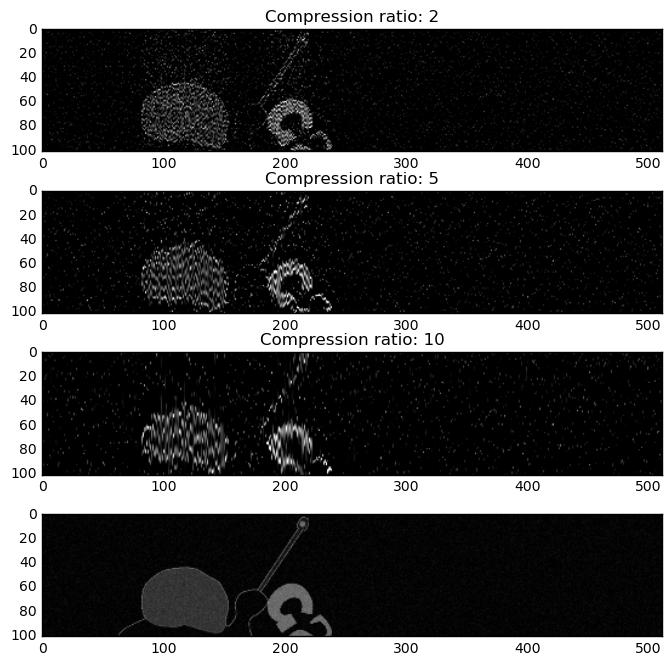

In [648]:
n = 11
print "SNR {}".format(SNR[n])
plt.figure(figsize=(8,8))
plt.subplot(411)
plt.imshow(rec_sim2[n][j,:,:].T, cmap='gray', vmax=15000)
plt.imsave("2.rec_example_cr2.png", rec_sim2[n][j,:,:].T, cmap='gray', vmax=15000)
plt.title("Compression ratio: 2")
plt.subplot(412)
plt.imshow(rec_sim5[n][j,:,:].T, cmap='gray', vmax=15000)
plt.title("Compression ratio: 5")
plt.imsave("2.rec_example_cr5.png", rec_sim5[n][j,:,:].T, cmap='gray', vmax=15000)

plt.subplot(413)
plt.imshow(rec_sim10[n][j,:,:].T, cmap='gray', vmax=15000)
plt.title("Compression ratio: 10")
plt.imsave("2.rec_example_cr10.png", rec_sim10[n][j,:,:].T, cmap='gray', vmax=15000)
plt.imsave("2.rec_example_cr20.png", rec_sim20[n][j,:,:].T, cmap='gray', vmax=15000)

plt.subplot(414)
rec_ref = np.abs(np.random.poisson(sim[j,:,:])+np.random.normal(0, get_signal(sim)/SNR[n]*(np.pi/2)**.5, size=exp[90,:,:].shape)).T
plt.imshow(rec_ref, cmap='gray', vmax=15000)
plt.imsave("2.rec_example_ref.png", rec_ref, cmap='gray', vmax=15000)


SNR 10
Signal level is: 5788.03931059


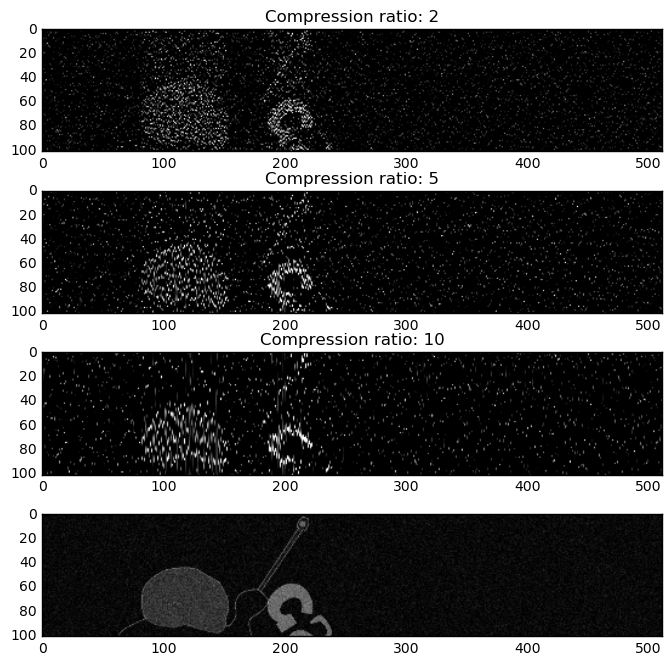

In [642]:
n = 9
print "SNR {}".format(SNR[n])
plt.figure(figsize=(8,8))
plt.subplot(411)
plt.imshow(rec_sim2[n][j,:,:].T, cmap='gray', vmax=15000)
plt.title("Compression ratio: 2")
plt.subplot(412)
plt.imshow(rec_sim5[n][j,:,:].T, cmap='gray', vmax=15000)
plt.title("Compression ratio: 5")
plt.subplot(413)
plt.imshow(rec_sim10[n][j,:,:].T, cmap='gray', vmax=15000)
plt.title("Compression ratio: 10")
plt.subplot(414)
plt.imshow(np.abs(np.random.poisson(sim[j,:,:])+np.random.normal(0, get_signal(sim)/SNR[n]*(np.pi/2)**.5, size=exp[90,:,:].shape)).T, cmap='gray', vmax=15000)

SNR 80


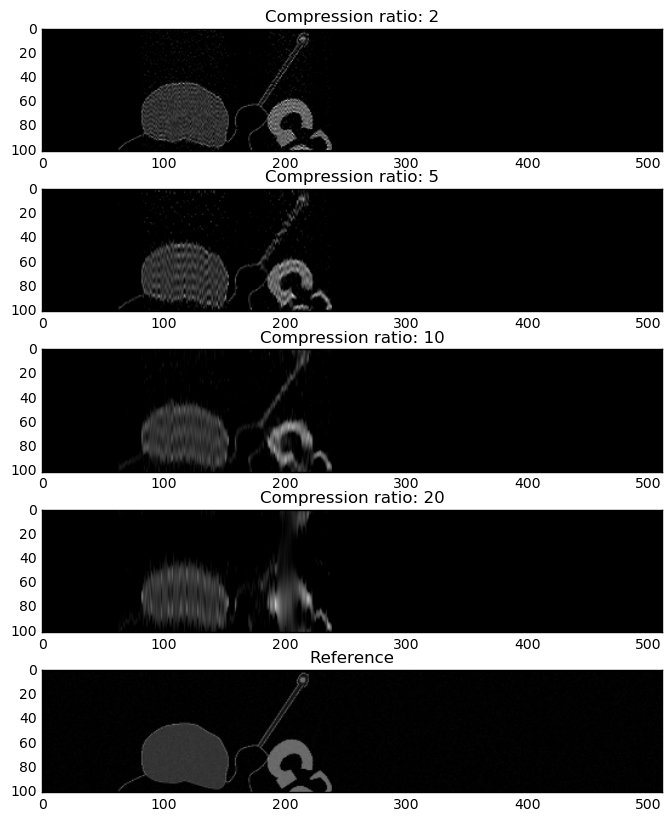

In [618]:
n = -2
print "SNR {}".format(SNR[n])
plt.figure(figsize=(8,10))
plt.subplot(511)
plt.imshow(rec_sim2[n][j,:,:].T, cmap='gray', vmin=0, vmax=15000)
plt.title("Compression ratio: 2")
plt.subplot(512)
plt.imshow(rec_sim5[n][j,:,:].T, cmap='gray', vmin=0, vmax=15000)
plt.title("Compression ratio: 5")
plt.subplot(513)
plt.imshow(rec_sim10[n][j,:,:].T, cmap='gray', vmin=0, vmax=15000)
plt.title("Compression ratio: 10")
plt.subplot(514)
plt.imshow(rec_sim20[n][j,:,:].T, cmap='gray', vmin=0, vmax=15000)
plt.title("Compression ratio: 20")
plt.subplot(515)
plt.imshow(np.abs(np.random.poisson(sim[j,:,:])+np.random.normal(0, float(signal)/SNR[n]*(np.pi/2)**.5, size=exp[90,:,:].shape)).T, cmap='gray', vmin=0, vmax=15000)
plt.title("Reference")
plt.savefig("2.reconstruction_examples.png", dpi=300)

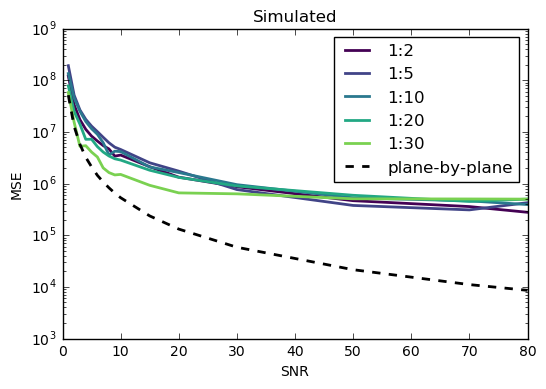

In [652]:
def clr(i, cmap='viridis'):
    """Returns a viridis color"""
    cm = plt.cm.get_cmap(cmap)
    return cm(i)

for (k,c) in enumerate(comp):
    plt.semilogy(SNR, [i[j] for i in MSE_sim[k]], color=clr(float(k)/len(comp)), linewidth=2, label="1:{}".format(c))
plt.semilogy(SNR, [i[j] for i in MSE_simref], '--', linewidth=2, color='black', label="plane-by-plane")
#plt.semilogy(SNR, [i[j] for i in MSE_simnoiref], '-', linewidth=2, color='black')
plt.xlabel('SNR'); plt.ylabel('MSE')
plt.title("Simulated")
plt.legend()
plt.savefig("2.MSE.pdf")

In [620]:
## Export the required figures for the explanation

## Original
plt.imsave("2.simuscheme_orig.png", sim[j,:,:].T, cmap='gray', vmax=15000)

## Noisy
plt.imsave("2.simuscheme_nois.png", np.abs(np.random.poisson(sim[j,:,:])+np.random.normal(0, float(signal)/SNR[5]*(np.pi/2)**.5, size=exp[90,:,:].shape)).T, cmap='gray', vmax=15000)
## Compressed
im = add_poisson(sim, b_norm)
im = np.abs(im + np.random.normal(0, .5*float(signal)/SNR[13]*(np.pi/2)**.5, size=im.shape)) ## We assume that the noise level is proportional to the illumination intensity

## Compressed
plt.imsave("2.simuscheme_comp.png", im[j,:,:10].T, cmap='gray', vmax=15000)

## Reconstructed
plt.imsave("2.simuscheme_reco.png", reco_image(im[j,:,:], comp=3).T, cmap='gray', vmax=15000)

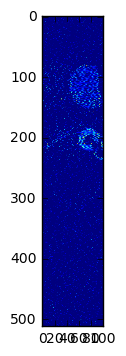

In [569]:
imr=reco_image(im[j,:,:], comp=4)
plt.imshow(imr)